In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imageio
from scipy import optimize
from scipy import special
import matplotlib.gridspec as gridspec
import os
import csv


def gaussian_1D(height, center, waist, offset):
    waist = float(waist)  # waist is defined as 1/e^2 of the intensity
    return lambda x: height * np.exp(-2 * ((center - x) / waist)**2) #+ offset

def bessel_intensity(x):
    return (special.jv(1,x)/x)**2

def bessel_1D(height,center,width,offset):
    width = float(width)
    return lambda x: height*bessel_intensity(3.831705970207512*(x-center)/width) #+ offset #First root of J_1(x): 3.831705970207512


def gaussian_2D(height, center_x, center_y, waist_x, waist_y, offset):
    """Returns a gaussian function with the given parameters"""
    # waist is defined as 1/e^2 of the intensity
    waist_x = float(waist_x)
    waist_y = float(waist_y)
    return lambda x, y: height * np.exp(-2 * (((center_x - x) / waist_x)**2 + ((center_y - y) / waist_y)**2)) #+ offset


def data_1D_av(data, i, j):
    data_i = np.sum(data, axis=0)
    data_j = np.sum(data, axis=1)
    return data_i, data_j


def moments_1D(data):
    """Returns (height, x, y, waist_x, waist_y)
    the gaussian parameters of a 1D distribution by calculating its
    moments """
    total = data.sum()
    I = np.indices(data.shape)
    i = (I * data).sum() / total
    waist = np.sqrt(np.abs((np.arange(data.size) - i)**2 * data).sum() / data.sum())
    height = data.max()
    offset = data.min()
    return height, i, waist, offset


def moments_2D(data):
    """Returns (height, x, y, waist_x, waist_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    I, J = np.indices(data.shape)
    # Find mass centre of intensity distribution
    i = (I * data).sum() / total
    j = (J * data).sum() / total
    col = data[:, int(j)]
    waist_i = np.sqrt(np.abs((np.arange(col.size) - i)**2 * col).sum() / col.sum())
    row = data[int(i), :]
    waist_j = np.sqrt(np.abs((np.arange(row.size) - j)**2 * row).sum() / row.sum())
    height = data.max()
    offset = data.min()
    return height, i, j, waist_i, waist_j, offset


def fitgaussian_1D(data):
    """Returns (height, i, j, waist_i, waist_j)
    the gaussian parameters of a 1D distribution found by a fit"""
    params = moments_1D(data)
 #   print(params)

    # gaussian_2D(*p) is a function taking two arguments, which are in the case used here two 2D matrices created by np.indices.
    # The error function is then a function depending on the parameters p which gets least if gaussian_2D best fits data.
    def errorfunction(p): return np.ravel(gaussian_1D(*p)(*np.indices(data.shape)) - data)

    p, pcov, infodict, errmsg, success = optimize.leastsq(errorfunction, params, full_output=1)
    # print('Gaussian_2D:')
    # print(gaussian_2D(*p))
    # print('Product:')
    # print((*np.indices(data.shape)))
    # print(gaussian_2D(*p)(*np.indices(data.shape)))
    # print('Data:')
    # print(data)

    return p, pcov, success

def fitbessel_1D(data):
    """Returns (height, i, j, waist_i, waist_j)
    the gaussian parameters of a 1D distribution found by a fit"""
    params = moments_1D(data)
 #   print(params)

    # gaussian_2D(*p) is a function taking two arguments, which are in the case used here two 2D matrices created by np.indices.
    # The error function is then a function depending on the parameters p which gets least if gaussian_2D best fits data.
    def errorfunction(p): return np.ravel(bessel_1D(*p)(*np.indices(data.shape)) - data)

    p, pcov, infodict, errmsg, success = optimize.leastsq(errorfunction, params, full_output=1)
    # print('Gaussian_2D:')
    # print(gaussian_2D(*p))
    # print('Product:')
    # print((*np.indices(data.shape)))
    # print(gaussian_2D(*p)(*np.indices(data.shape)))
    # print('Data:')
    # print(data)

    return p, pcov, success


def fitgaussian_2D(data):
    """Returns (height, i, j, waist_i, waist_j)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments_2D(data)
 #   print(params)

    # gaussian_2D(*p) is a function taking two arguments, which are in the case used here two 2D matrices created by np.indices.
    # The error function is then a function depending on the parameters p which gets least if gaussian_2D best fits data.
    def errorfunction(p): return np.ravel(gaussian_2D(*p)(*np.indices(data.shape)) - data)

    p, pcov, infodict, errmsg, success = optimize.leastsq(errorfunction, params, full_output=1)
    # print('Gaussian_2D:')
    # print(gaussian_2D(*p))
    # print('Product:')
    # print((*np.indices(data.shape)))
    # print(gaussian_2D(*p)(*np.indices(data.shape)))
    # print('Data:')
    # print(data)

    return p, pcov, success


def fit_gaussian_2D_to_image(filename, pixelsize_x=3.75, pixelsize_y=3.75, sliceing=None, return_value=True):
    data = np.array(imageio.imread(filename)).astype('int64')
#    print(data.shape)
    if len(data.shape) == 3:
        if data.shape[2] == 3:
            data = data[:, :, 0]

    if sliceing is not None:
        data = data[sliceing[0][0]:sliceing[0][1], sliceing[1][0]:sliceing[1][1]]

    fig = plt.figure(figsize=(5, 4), tight_layout=True)
    #plt.matshow(data, cmap=plt.cm.gist_earth_r)
    plt.matshow(data, cmap='jet')

    params, pcov, success = fitgaussian_2D(data)
    fit = gaussian_2D(*params)

    plt.contour(fit(*np.indices(data.shape)))
    ax = plt.gca()
    ax.xaxis.set_tick_params(labeltop='off', labelbottom='on')
    (height, i, j, waist_i, waist_j, offset) = params
    print('2D params are:')
    print(params)
#    print(np.sqrt(np.diag(pcov)))
#    print(success)
    plt.text(0.95, 0.05, """
    waist_x : %.1fum
    waist_y : %.1fum""" % (waist_j * pixelsize_x, waist_i * pixelsize_y),
             fontsize=12, horizontalalignment='right', color='r',
             verticalalignment='bottom', transform=ax.transAxes)
    plt.text(0.95, 0.15, """
    center_x : %.1fum
    center_y : %.1fum""" % (j * pixelsize_x, i * pixelsize_y),
             fontsize=12, horizontalalignment='right', color='r',
             verticalalignment='bottom', transform=ax.transAxes)
    red_filename = filename.split('/')[-1]
    plt.text(0.7, 0.9, red_filename,
             fontsize=12, horizontalalignment='right', color='r',
             verticalalignment='bottom', transform=ax.transAxes)
    ax.set_xlabel('x-axis camera')
    ax.set_ylabel('y-axis camera')
    
    # fig.tight_layout()
    plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')
    if return_value:
        return red_filename, j * pixelsize_x, i * pixelsize_y


def fit_gaussian_1D_to_image(filename, pixelsize_x=3.75, pixelsize_y=3.75):
    data = np.array(imageio.imread(filename)).astype('int64')
#    print(data.shape)
    if len(data.shape) == 3:
        if data.shape[2] == 3:
            data = data[:, :, 0]
    gs = gridspec.GridSpec(3, 2, height_ratios=[2, 2, 1])

    fig = plt.figure(figsize=(10, 15), tight_layout=True)

    ax1 = plt.subplot(gs[0:2, :])  # row 0, span all columns
    ax1.matshow(data, cmap='jet')

    params, pcov, success = fitgaussian_2D(data)
    fit = gaussian_2D(*params)

    ax1.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
    ax1.xaxis.set_tick_params(labeltop='off', labelbottom='on')
    ax1.set_xlabel('x-axis camera')
    ax1.set_ylabel('y-axis camera')
    #axtext = ax1.gca()
    (height, i, j, waist_i, waist_j, offset) = params
    print('2D params are:')
    print(params)
#    print(np.sqrt(np.diag(pcov)))
#    print(success)
    ax1.text(0.95, 0.05, """
    waist_x : %.2fum
    waist_y : %.2fum""" % (waist_j * pixelsize_x, waist_i * pixelsize_y),
             fontsize=16, horizontalalignment='right', color='r',
             verticalalignment='bottom', transform=ax1.transAxes)
    ax1.text(0.5, 0.9, filename,
             fontsize=16, horizontalalignment='right', color='r',
             verticalalignment='bottom', transform=ax1.transAxes)
    data_i, data_j = data[:, int(np.round(j, 0))], data[int(np.round(i, 0)), :]
    filename += '.pdf'

    params_i, pcov_i, success_i = fitgaussian_1D(data_i)
    params_j, pcov_j, success_j = fitgaussian_1D(data_j)
    
    ax1.set_ylim(max(0,params_i[1] - 5 * params_i[2]), min(len(data_i),params_i[1] + 5 * params_i[2]))
    ax1.set_xlim(max(0,params_j[1] - 5 * params_j[2]), min(len(data_j),params_j[1] + 5 * params_j[2]))
    print('1D_gaussian_x params are:')
    print(params_j)
    print('1D_gaussian_y params are:')
    print(params_i)
    waist_i_1D, waist_j_1D = params_i[2], params_j[2]
    
    # Be aware that i is the row-index specifying the vertical (so the y-) axis of the image. Correspondingly j is the index for the x-axis.
    fit_i = gaussian_1D(*params_i)
    fit_j = gaussian_1D(*params_j)
    
    #params_bessel_i, pcov_i, success_i = fitbessel_1D(data_i)
    #params_bessel_j, pcov_j, success_j = fitbessel_1D(data_j)
    #print('1D_bessel_x params are:')
    #print(params_j)
    #print('1D_bessel_y params are:')
    #print(params_i)
    #zero_i_1D, zero_j_1D = params_bessel_i[2], params_bessel_j[2]

    # Be aware that i is the row-index specifying the vertical (so the y-) axis of the image. Correspondingly j is the index for the x-axis.
    #fit_bessel_i = bessel_1D(*params_bessel_i)
    #fit_bessel_j = bessel_1D(*params_bessel_j)

    ax2 = plt.subplot(gs[2, 0])  # row 1, col 0
    ax2.plot(data_i, 'r', markersize=1)
    ax2.plot(fit_i(*np.indices(data_i.shape)),label= "Gaussian-waist = %.2fum" % (waist_i_1D* pixelsize_y))
    #ax2.plot(fit_bessel_i(*np.indices(data_i.shape)),label= "Bessel: zero = %.2fum, 1/e²-radius = %.2fum" 
    #         % (zero_i_1D * pixelsize_y, 0.6743312273840637*zero_i_1D * pixelsize_y),color="C4")
    ax2.set_xlim(max(0,params_i[1] - 3 * params_i[2]),min(len(data_i), params_i[1] + 3 * params_i[2]))
    ax2.set_title("y-cross section (max. intensity)",fontsize=16)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True,fontsize=12)

    ax3 = plt.subplot(gs[2, 1])  # row 1, col 1
    ax3.plot(data_j, 'r', markersize=1)
    ax3.plot(fit_j(*np.indices(data_j.shape)),label= "Gaussian-waist = %.2fum" % (waist_j_1D* pixelsize_x))
    #ax3.plot(fit_bessel_j(*np.indices(data_j.shape)),label= "Bessel: zero = %.2fum, 1/e²-radius = %.2fum" 
    #         % (zero_j_1D * pixelsize_x, 0.6743312273840637*zero_j_1D * pixelsize_x),color="C4")
    ax3.set_xlim(max(0,params_j[1] - 3 * params_j[2]), min(len(data_j),params_j[1] + 3 * params_j[2]))
    ax3.set_title("x-cross section (max. intensity)",fontsize=16)
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True,fontsize=12)

    plt.savefig(filename, format='pdf')


2D params are:
[35467.76585692   232.66239126   357.77912233   260.7699206
   276.62863154  2784.        ]
1D_gaussian_x params are:
[38131.01299719   358.4331466    255.05443799  3856.        ]
1D_gaussian_y params are:
[36570.95976372   230.42560884   255.64816931  7072.        ]
2D params are:
[30912.08163268   236.16527615   288.4051264    249.62064479
   249.28467985  1088.        ]
1D_gaussian_x params are:
[32160.62651974   288.51286467   239.57263752  2032.        ]
1D_gaussian_y params are:
[31449.09122539   236.63606357   248.55343715  4912.        ]


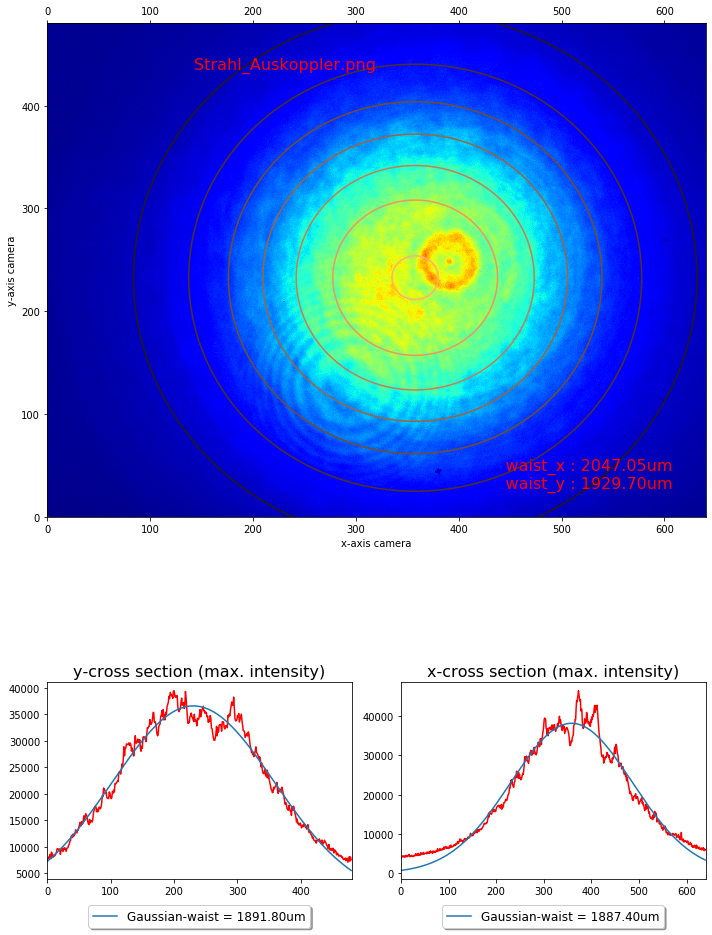

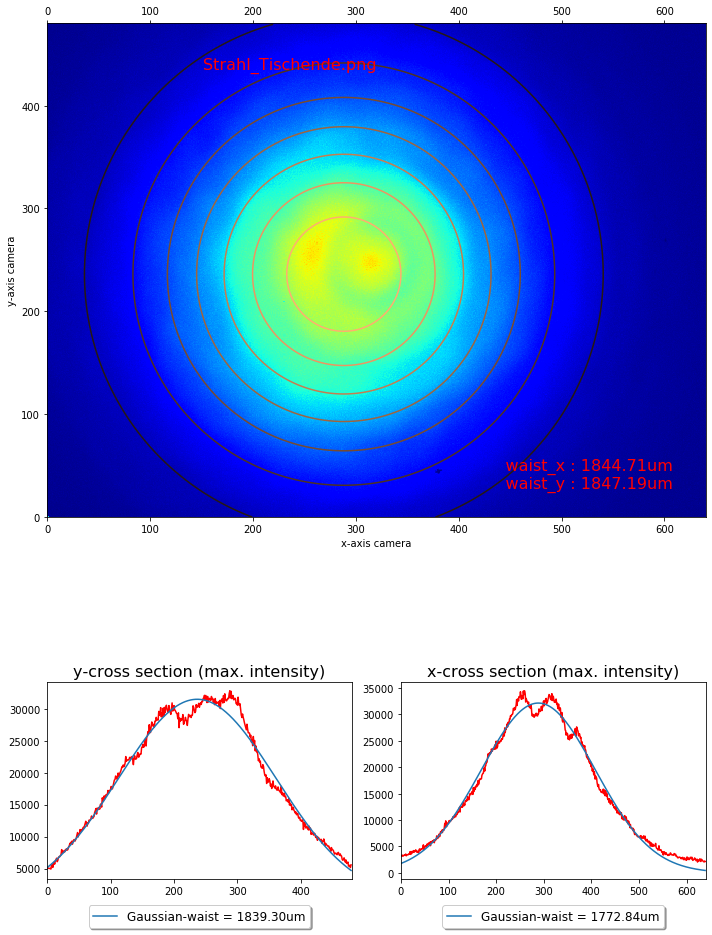

In [5]:
fit_gaussian_1D_to_image('Strahl_Auskoppler.png',pixelsize_x=7.4,pixelsize_y=7.4)
fit_gaussian_1D_to_image('Strahl_Tischende.png',pixelsize_x=7.4,pixelsize_y=7.4)

2D params are:
[37266.56172655   230.05323777   333.09378866   230.20535173
   228.05558881  1280.        ]
1D_gaussian_x params are:
[41900.73779062   332.77910177   204.12329528  2576.        ]
1D_gaussian_y params are:
[40826.06192537   229.95847824   213.21441473  4912.        ]
2D params are:
[39077.32508847   218.27828162   292.90364471   210.46719028
   206.87276848   592.        ]
1D_gaussian_x params are:
[42046.61069794   292.51290185   191.82882978  1232.        ]
1D_gaussian_y params are:
[43095.1710999    219.44243259   194.32459772  3360.        ]


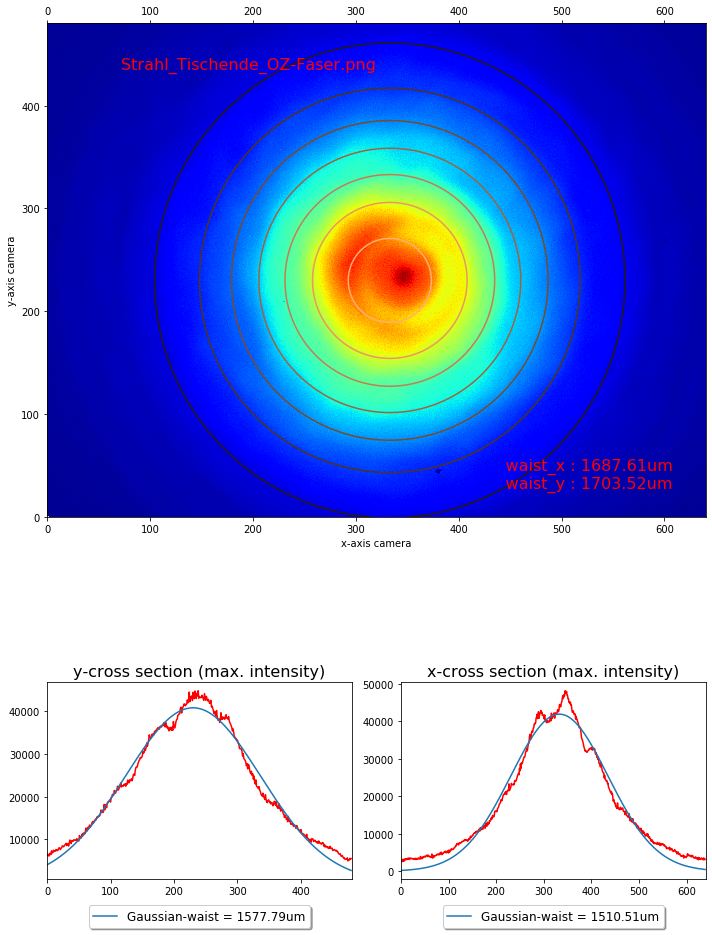

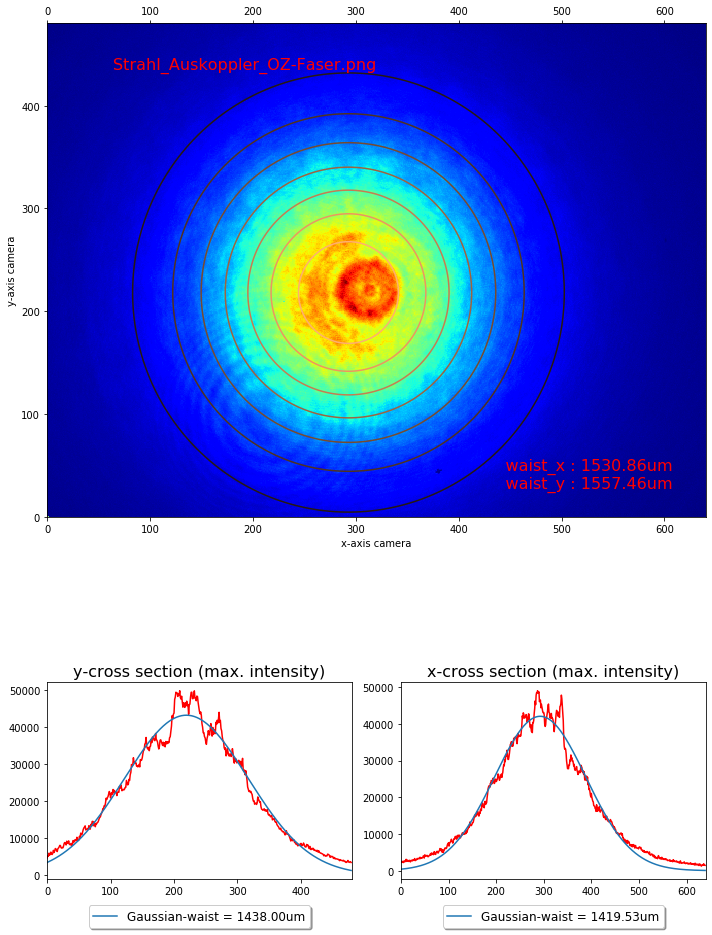

In [6]:
fit_gaussian_1D_to_image('Strahl_Tischende_OZ-Faser.png',pixelsize_x=7.4,pixelsize_y=7.4)
fit_gaussian_1D_to_image('Strahl_Auskoppler_OZ-Faser.png',pixelsize_x=7.4,pixelsize_y=7.4)

2D params are:
[162.26701413 439.8383347  469.76420811 378.37657769 389.30949657
   3.        ]
1D_gaussian_x params are:
[176.31491831 468.21833572 363.26560043   5.        ]
1D_gaussian_y params are:
[169.69025717 444.91547366 352.69363814  11.        ]
2D params are:
[157.21585529 472.22539617 647.02158882 421.50081264 447.8537404
   1.        ]
1D_gaussian_x params are:
[166.98229272 646.29199434 427.28303803  10.        ]
1D_gaussian_y params are:
[161.56266114 497.34015769 390.41543311  15.        ]


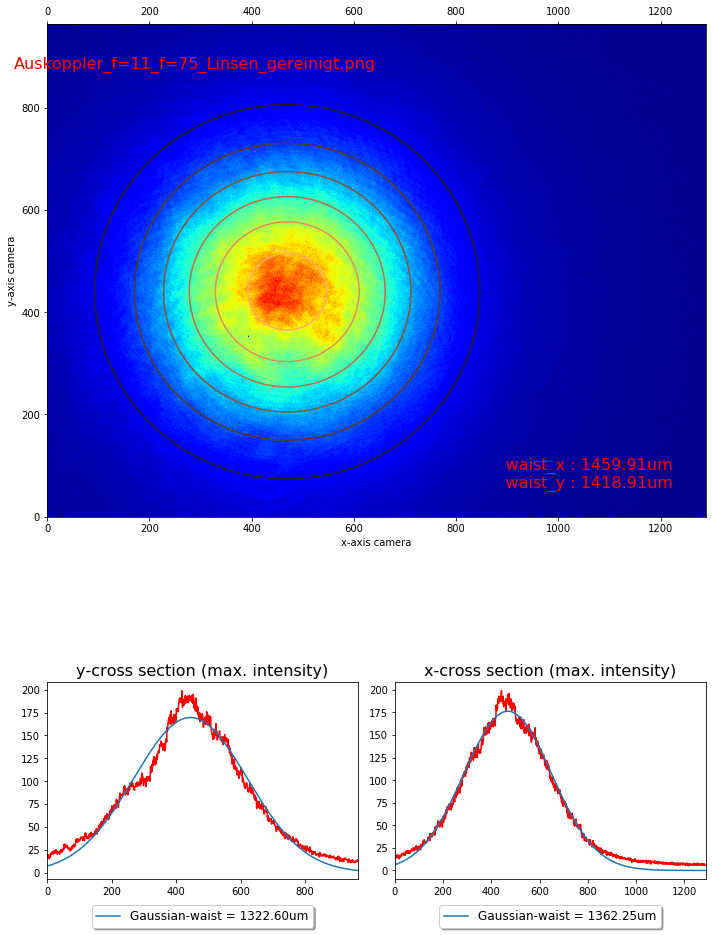

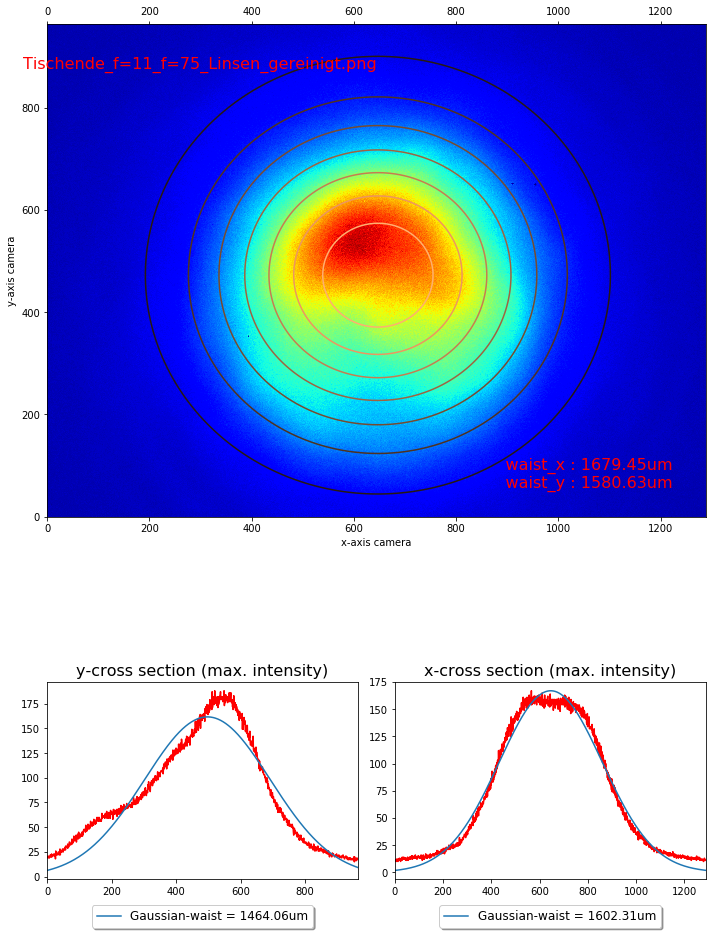

In [7]:
fit_gaussian_1D_to_image('Auskoppler_f=11_f=75_Linsen_gereinigt.png',pixelsize_x=3.75,pixelsize_y=3.75)
fit_gaussian_1D_to_image('Tischende_f=11_f=75_Linsen_gereinigt.png',pixelsize_x=3.75,pixelsize_y=3.75)

2D params are:
[40608.45846933   239.35428876   317.19891817   203.87335377
   202.28707064   352.        ]
1D_gaussian_x params are:
[41956.9392344    315.39750152   192.09452111  1312.        ]
1D_gaussian_y params are:
[42678.3831073    238.86104728   195.4741257   3216.        ]
2D params are:
[35188.36296372   241.71119562   317.32607863   228.30800343
   230.5809219    768.        ]
1D_gaussian_x params are:
[40101.17349496   317.2975219    204.39369483  2176.        ]
1D_gaussian_y params are:
[41700.42189812   240.87109358   199.77829799  4224.        ]


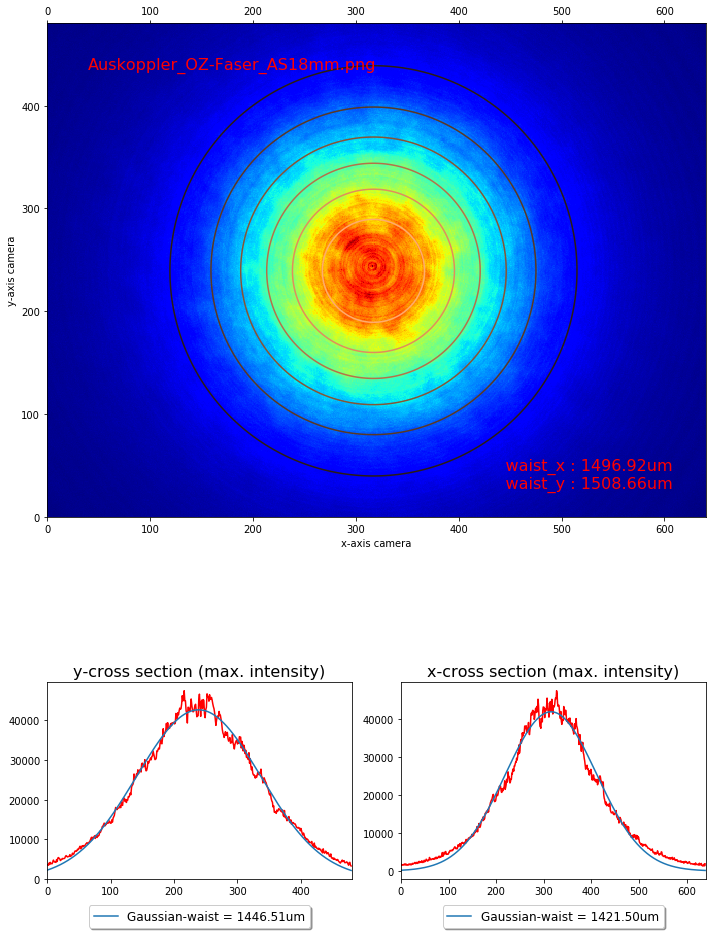

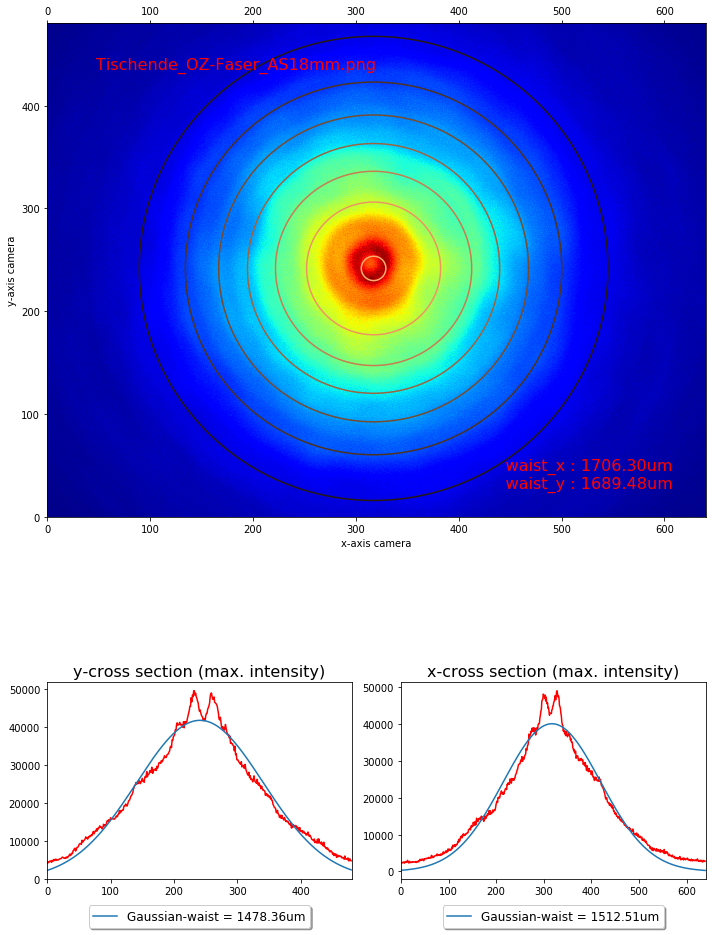

In [8]:
fit_gaussian_1D_to_image('Auskoppler_OZ-Faser_AS18mm.png',pixelsize_x=7.4,pixelsize_y=7.4)
fit_gaussian_1D_to_image('Tischende_OZ-Faser_AS18mm.png',pixelsize_x=7.4,pixelsize_y=7.4)